In this notebook we will perform classification analysis on data from the NEPR207 2018 datasets.

Note from dan:

Responses are percentages relative to 1 so you probably want to subtract 1 or z-score before doing classification.

368/369/370 all have two conditions (attend left/right or stimulus rotated left/right) group 371 has three conditions (task difficulty = 1/2/4)


In [181]:
import os
import scipy.io,scipy.stats
import numpy,pandas
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

subcodes=['s036820180521','s036920180521','s037020180521','s037120180521']


In [162]:
def get_data(subcode,timepoint=3):
    lV1_instances=scipy.io.loadmat(os.path.join('..',subcode,'%d_lV1_instances.mat'%timepoint))['data']
    labels=scipy.io.loadmat(os.path.join('..',subcode,'%d_lV1_labels.mat'%timepoint))['cond'][:,0]
    rV1_instances=scipy.io.loadmat(os.path.join('..',subcode,'%d_rV1_instances.mat'%timepoint))['data']

    instances=numpy.hstack((lV1_instances,rV1_instances))
    assert instances.shape[0]==labels.shape[0]
    return(labels,instances)

Build a classifier to predict condition from V1 data

In [213]:
def run_classifier(labels,instances,shuffle=False,
                   cv=None,clf=None,nPCs=0):
    """
    run classifier on input data
    shuffle: randomly shuffle labels
    cv: crossvalidation operator (default of 4-fold if None)
    clf: classifier (default of LinearSVC if none)
    nPCs: if 0 then no PCA is performed. if >0, then data reduced to nPCs components
    """
    if cv is None:
        cv=sklearn.model_selection.KFold(n_splits=4,shuffle=True,random_state=0)

    if clf is None:
        clf=sklearn.svm.LinearSVC()
        
    predicted_labels=numpy.zeros(labels.shape)
    scaler=sklearn.preprocessing.StandardScaler()
    labels_copy=labels.copy()  # to prevent shuffle from affecting original variable

    for train,test in cv.split(instances):
        if shuffle:
            numpy.random.shuffle(labels_copy)
        train_X,test_X=instances[train,:],instances[test,:]
        train_Y,test_Y=labels_copy[train],labels_copy[test]
        if nPCs>0:
            pca=sklearn.decomposition.PCA(n_components=nPCs)
            train_X=pca.fit_transform(train_X)
            test_X=pca.transform(test_X)
        train_X=scaler.fit_transform(train_X)
        test_X=scaler.transform(test_X)
        clf.fit(train_X,train_Y)
        predicted_labels[test]=clf.predict(test_X)
    return(predicted_labels)

def print_metrics(labels,predicted_labels):
    print('Confusion matrix:')
    print(sklearn.metrics.confusion_matrix(labels,predicted_labels))
    print('Accuracy:',sklearn.metrics.accuracy_score(labels,predicted_labels))


In [209]:
clf=None  # none for LinearSVC
clf=sklearn.linear_model.LogisticRegressionCV()
nruns=100 # how many random shuffles to do
cutoff=95

accuracy=numpy.zeros((len(subcodes),10))
accuracy_shuf=numpy.zeros((len(subcodes),10))

for i,subcode in enumerate(subcodes):
    print('running for subcode ',subcode)
    for tp in range(10):
        labels,instances=get_data(subcode,tp+1)
        predicted_labels=run_classifier(labels,instances,shuffle=False,clf=clf)
        accuracy[i,tp]=sklearn.metrics.accuracy_score(labels,predicted_labels)
        # run 10 times to get mean of shuffled accuracy
        shuffle_acc=numpy.zeros(nruns)
        for r in range(nruns):
            predicted_labels=run_classifier(labels,instances,shuffle=True)
            shuffle_acc[r]=sklearn.metrics.accuracy_score(labels,predicted_labels)
        accuracy_shuf[i,tp]=scipy.stats.scoreatpercentile(shuffle_acc,cutoff)

running for subcode  s036820180521
running for subcode  s036920180521
running for subcode  s037020180521
running for subcode  s037120180521


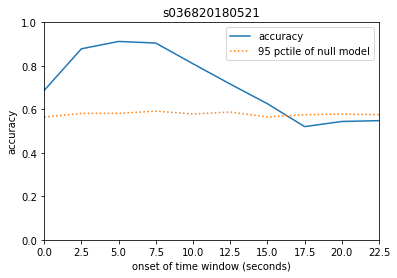

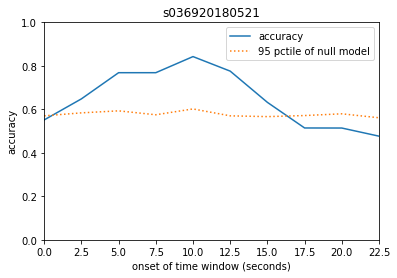

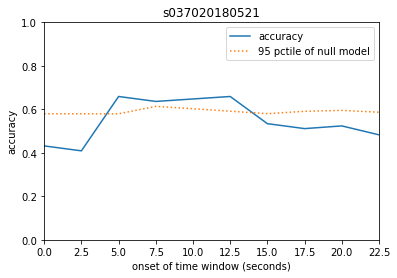

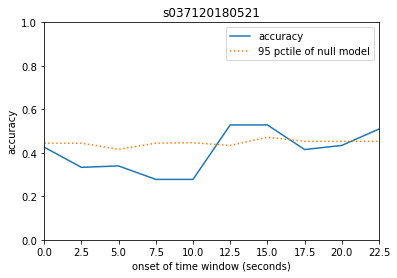

In [210]:
for i,subcode in enumerate(subcodes):
    plt.figure()
    timepoints=numpy.arange(10)*2.5
    plt.plot(timepoints,accuracy[i,:],label='accuracy')
    plt.plot(timepoints,accuracy_shuf[i,:],label='%d pctile of null model'%cutoff,
            linestyle='dotted')
    plt.xlabel('onset of time window (seconds)')
    plt.ylabel('accuracy')
    plt.title(subcode)
    plt.axis([0,numpy.max(timepoints),0,1])
    plt.legend()

Now let's examine how much data we actually need to do the classification.  We will perform PCA at a range of dimensionalities and then perform classification on the data after projecting it into the lower dimensional space.

In [200]:
pcvals=numpy.arange(1,6)
accuracy_pca=numpy.zeros((len(subcodes),10,len(pcvals)))

for i,subcode in enumerate(subcodes):
    print('running for subcode ',subcode)
    for tp in range(10):
      for j,nPCs in enumerate(pcvals):
        labels,instances=get_data(subcode,tp+1)
        predicted_labels=run_classifier(labels,instances,shuffle=False,clf=clf,nPCs=nPCs)
        accuracy_pca[i,tp,j]=sklearn.metrics.accuracy_score(labels,predicted_labels)


running for subcode  s036820180521
running for subcode  s036920180521
running for subcode  s037020180521
running for subcode  s037120180521


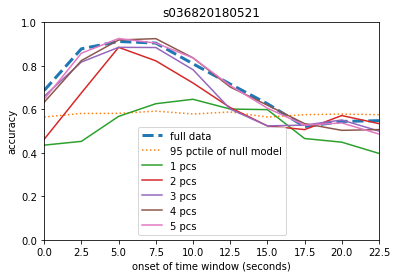

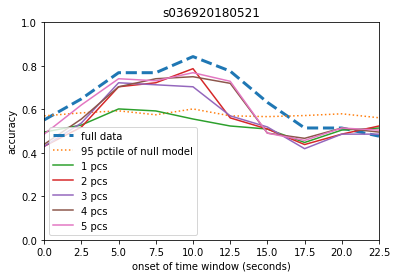

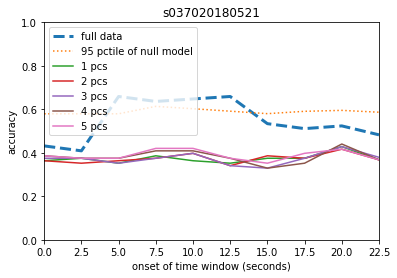

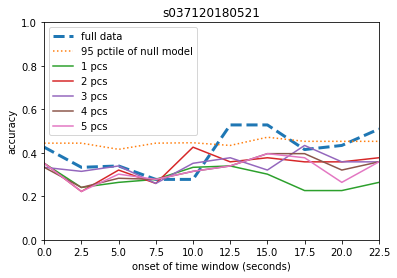

In [214]:
for i,subcode in enumerate(subcodes):
    plt.figure()
    timepoints=numpy.arange(10)*2.5
    plt.plot(timepoints,accuracy[i,:],label='full data',linestyle='dashed',linewidth=3)
    plt.plot(timepoints,accuracy_shuf[i,:],label='%d pctile of null model'%cutoff,
            linestyle='dotted')
    for j,nPCs in enumerate(pcvals[:5]):
        plt.plot(timepoints,accuracy_pca[i,:,j],label='%d PCs'%nPCs)
        
    plt.xlabel('onset of time window (seconds)')
    plt.ylabel('accuracy')
    plt.title(subcode)
    plt.axis([0,numpy.max(timepoints),0,1])
    plt.legend()